In [332]:
from __future__ import absolute_import
from __future__ import print_function
import PIL
import torch
import glob as gb
import numpy as np
from PIL import Image
import pandas as pd

import pylab as plt
import model.resnet50_128 as model

from sklearn.model_selection import train_test_split


from torch.utils.data import Dataset, DataLoader

import os
import shutil

In [28]:
# hyper parameters
batch_size = 10
mean = (131.0912, 103.8827, 91.4953)

In [29]:
def load_data(path='', shape=None):
    short_size = 224.0
    crop_size = shape
    img = PIL.Image.open(path)
    im_shape = np.array(img.size)    # in the format of (width, height, *)
    img = img.convert('RGB')

    ratio = float(short_size) / np.min(im_shape)
    img = img.resize(size=(int(np.ceil(im_shape[0] * ratio)),   # width
                           int(np.ceil(im_shape[1] * ratio))),  # height
                     resample=PIL.Image.BILINEAR)

    x = np.array(img)  # image has been transposed into (height, width)
    newshape = x.shape[:2]
    h_start = (newshape[0] - crop_size[0])//2
    w_start = (newshape[1] - crop_size[1])//2
    x = x[h_start:h_start+crop_size[0], w_start:w_start+crop_size[1]]
    x = x - mean
    return x

In [30]:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

In [31]:
def initialize_model():
    # Download the pytorch model and weights.
    # Currently, it's cpu mode.
    network = model.resnet50_128(weights_path='./model/resnet50_128.pth')
    network.eval()
    return network

In [70]:
def image_encoding(model, facepaths):
    print('==> compute image-level feature encoding.')
    num_faces = len(facepaths)
    face_feats = np.empty((num_faces, 128))
    imgpaths = facepaths
    imgchunks = list(chunks(imgpaths, batch_size))
    # print(num_faces, face_feats, imgpaths, imgchunks)

    for c, imgs in enumerate(imgchunks):
        im_array = np.array([load_data(path=i, shape=(224, 224, 3)) for i in imgs])
        f = model(torch.Tensor(im_array.transpose(0, 3, 1, 2)))[1].detach().cpu().numpy()[:, :, 0, 0]
        start = c * batch_size
        end = min((c + 1) * batch_size, num_faces)
        # This is different from the Keras model where the normalization has been done inside the model.
        face_feats[start:end] = f / np.sqrt(np.sum(f ** 2, -1, keepdims=True))
        if c % 50 == 0:
            print('-> finish encoding {}/{} images.'.format(c * batch_size, num_faces))
    return face_feats

In [71]:
model_eval.feat_extract

Conv2d(2048, 128, kernel_size=[1, 1], stride=(1, 1), bias=False)

In [74]:
print(face_feats.shape)

(64, 128)


==> compute image-level feature encoding.
-> finish encoding 0/64 images.


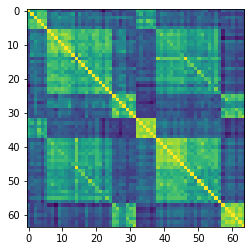

In [73]:
# rename samples (test set)/tight_crop -> samples
facepaths = gb.glob('/storage/Study/neuro2/ABBYY/vgg_face2/samples/*/*/*.jpg')
model_eval = initialize_model()
face_feats = image_encoding(model_eval, facepaths)


S = np.dot(face_feats, face_feats.T)


plt.imshow(S)
plt.show()

In [165]:
folder1 = gb.glob('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/*.jpg')
folder2 = gb.glob('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/*.jpg')

In [166]:
model_eval = initialize_model()
folder1_face_feats = image_encoding(model_eval, folder1)
folder2_face_feats = image_encoding(model_eval, folder2)

==> compute image-level feature encoding.
-> finish encoding 0/11 images.
==> compute image-level feature encoding.
-> finish encoding 0/2 images.


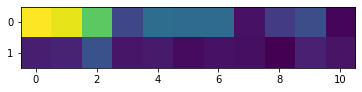

In [167]:
S = np.dot(folder2_face_feats, folder1_face_feats.T)
plt.imshow(S)
plt.show()

In [212]:
results = [(folder2[i], folder1[images.argmax()]) for i, images in enumerate(S)]

In [213]:
results

[('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/0.jpg',
  '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/1.jpg'),
 ('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/2.jpg',
  '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/100.jpg')]

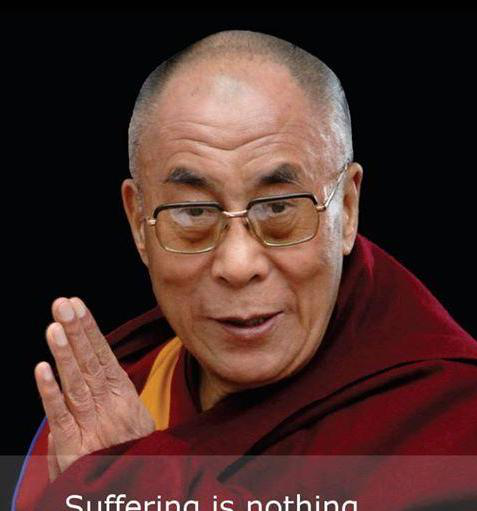

In [216]:
Image.open('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/0.jpg').convert('RGB')

In [214]:
# results = []
# for i, images in enumerate(S):
#     results.append(folder2[i])
#     results.append(folder1[images.argmax()])

In [217]:
results

['/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/0.jpg',
 '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/1.jpg',
 '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/2.jpg',
 '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/100.jpg']

In [228]:
def predict(folder1:str, folder2:str) -> list:
    images1 = gb.glob(folder1 + '*.jpg')
    images2 = gb.glob(folder2 + '*.jpg')
    model_eval = initialize_model()
    folder1_face_feats = image_encoding(model_eval, images1)
    folder2_face_feats = image_encoding(model_eval, images2)

    S = np.dot(folder2_face_feats, folder1_face_feats.T)

    plt.imshow(S)
    plt.show()

    return [(images2[i], images1[images.argmax()]) for i, images in enumerate(S)]

==> compute image-level feature encoding.
-> finish encoding 0/11 images.
==> compute image-level feature encoding.
-> finish encoding 0/2 images.


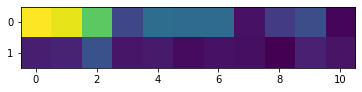

[('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/0.jpg',
  '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/1.jpg'),
 ('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/2.jpg',
  '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/100.jpg')]

In [229]:
predict('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/', '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/')

In [236]:
def predict_once(folder1:str, image2:str) -> str:
    images1 = gb.glob(folder1 + '*.jpg')
    images2 = gb.glob(image2)
    model_eval = initialize_model()
    folder1_face_feats = image_encoding(model_eval, images1)
    folder2_face_feats = image_encoding(model_eval, images2)

    S = np.dot(folder2_face_feats, folder1_face_feats.T)

    plt.imshow(S)
    plt.show()

    return images1[S.argmax()]

==> compute image-level feature encoding.
-> finish encoding 0/11 images.
==> compute image-level feature encoding.
-> finish encoding 0/1 images.


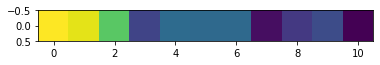

'/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/1.jpg'

In [237]:
predict_once('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/', '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/0.jpg')

In [280]:
# !ls -la
names = pd.read_csv('/storage/Study/neuro2/ABBYY/names.tsv', delimiter='\t', names=['class', 'image'])

In [298]:
names['image'] = names['image'].apply(str).apply(lambda x: f'/storage/Study/neuro2/ABBYY/test/{x}.jpg')

In [299]:
names.head()

,class,image
0,0,/storage/Study/neuro2/ABBYY/test/0.jpg
1,0,/storage/Study/neuro2/ABBYY/test/1.jpg
2,0,/storage/Study/neuro2/ABBYY/test/2.jpg
3,0,/storage/Study/neuro2/ABBYY/test/3.jpg
4,0,/storage/Study/neuro2/ABBYY/test/4.jpg


In [306]:
num_classes = names['class'].value_counts().count()
num_classes

500

In [323]:
sample = []
for i in range(500):
    row = names[names['class'] == i].iloc[0]
    sample.append((row['class'], row['image']))

In [316]:
names[names['class'] == 0].iloc[0]['image']

'/storage/Study/neuro2/ABBYY/test/0.jpg'

In [330]:
sample

(1, '/storage/Study/neuro2/ABBYY/test/423.jpg')

In [333]:
for i in sample:
    shutil.copy(i[1], "/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/"+i[1].split('/')[-1])

In [353]:
for i in names['image'][:1000]:
    shutil.copy(i, "/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/"+i.split('/')[-1])

==> compute image-level feature encoding.
-> finish encoding 0/500 images.
==> compute image-level feature encoding.
-> finish encoding 0/1000 images.
-> finish encoding 500/1000 images.


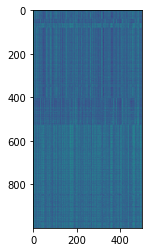

In [355]:
predictions = predict('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/', '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/')

In [357]:
predictions[:10]

[('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/479.jpg',
  '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/423.jpg'),
 ('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/0.jpg',
  '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/0.jpg'),
 ('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/1.jpg',
  '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/0.jpg'),
 ('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/10.jpg',
  '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/0.jpg'),
 ('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/100.jpg',
  '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/0.jpg'),
 ('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/101.jpg',
  '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/0.jpg'),
 ('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/102.jpg',
  '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/0.jpg'),
 ('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/103.jpg',
  '/storage/Study/ne

In [363]:
predictions[0]

('/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder2/479.jpg',
 '/storage/Study/neuro2/ABBYY/abbyy_test/test1/folder1/423.jpg')

In [378]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

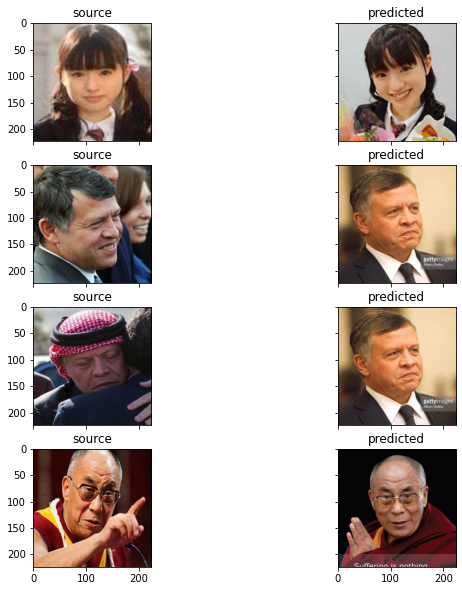

In [391]:
Ni = 4

fig, ax = plt.subplots(nrows=Ni, ncols=2,figsize=(10, 10), \
                        sharey=True, sharex=True)

for i in range(Ni):
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, 1000))
        predicted, source = face_dataset[random_characters]

        imshow(predicted, title='source',plt_ax=ax[i ,0])
        imshow(source, title='predicted',plt_ax=ax[i ,1])

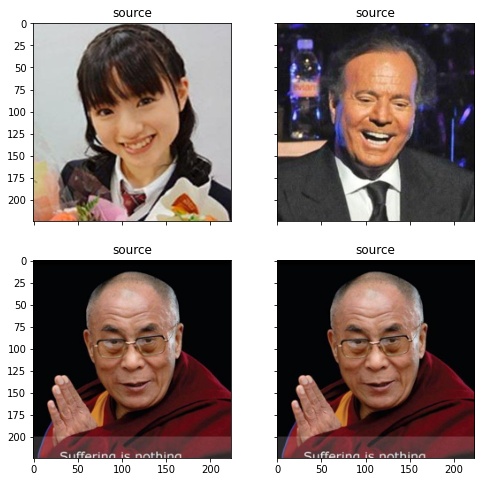

In [382]:
Ni = 2

fig, ax = plt.subplots(nrows=Ni, ncols=2,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    predicted, source = face_dataset[random_characters]

    imshow(predicted, title='predicted',plt_ax=fig_x)
    imshow(source, title='source',plt_ax=fig_x)

In [368]:
# 

In [376]:
face_dataset = FacesDataset(predictions)

In [375]:
class FacesDataset(Dataset):
    """
    """
    def __init__(self, predictions):
        super().__init__()

        self.predictions = predictions


    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image
    
    def __len__(self):
         pass
  
    def __getitem__(self, index):
        predicted = self._prepare_sample(self.load_sample(self.predictions[index][0]))
        source = self._prepare_sample(self.load_sample(self.predictions[index][1]))
        return predicted, source
    

In [358]:
class FacesDataset(Dataset):
    """
    """
    def __init__(self, table):
        super().__init__()

        # self.classes = table['classes']
        # self.images_pth = table['image']


    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)
    
    def __len__(self):
         pass
  
    def __getitem__(self, index):
        

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
    

In [267]:
files = gb.glob('/storage/Study/neuro2/ABBYY/test/*.jpg')

In [278]:
files[0].split('/')[-1].split('.')[-2]

'0'

In [263]:
sorted(gb.glob('/storage/Study/neuro2/ABBYY/test/*.jpg'))[:10]

['/storage/Study/neuro2/ABBYY/test/0.jpg',
 '/storage/Study/neuro2/ABBYY/test/1.jpg',
 '/storage/Study/neuro2/ABBYY/test/10.jpg',
 '/storage/Study/neuro2/ABBYY/test/100.jpg',
 '/storage/Study/neuro2/ABBYY/test/1000.jpg',
 '/storage/Study/neuro2/ABBYY/test/10000.jpg',
 '/storage/Study/neuro2/ABBYY/test/100000.jpg',
 '/storage/Study/neuro2/ABBYY/test/100001.jpg',
 '/storage/Study/neuro2/ABBYY/test/100002.jpg',
 '/storage/Study/neuro2/ABBYY/test/100003.jpg']

In [204]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

/
s
t
o


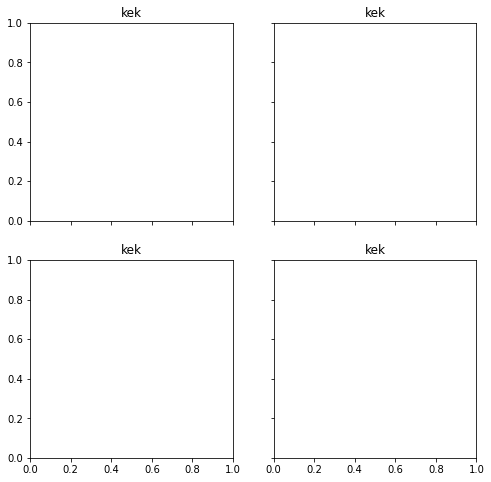

In [207]:
RESCALE_SIZE = 224

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), \
                        sharey=True, sharex=True
                        )
for i, fig_x in enumerate(ax.flatten()):
    image = Image.open(results[i])
    image.resize((RESCALE_SIZE, RESCALE_SIZE))
    print(results[0][i])
    imshow(np.array(image), title='kek', plt_ax=fig_x)

